### EXEMPLOS BASICOS

Baseado em: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras - Part 1

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Funções úteis

Estas funções serão usadas para facilitar o plot de imagens nesse notebook. Não iremos nos ater a elas no momento.

In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    """
    func: lambda func for prediction
    X: data array
    y: data classes array
    figsize: output figure size, default is set
    """
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    """
    model: compiled model
    X: data array
    y: data classes array
    """
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    """
    X: data array
    y: data classes array
    """
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    """
    history: fit model history
    """
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

# not used in this notebook
def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])

# not used in this notebook
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4.0)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

### Modelo simples linear

Vamos utilizar a função make_classification da lib Keras para gerar um dataset simples com 2 classes.

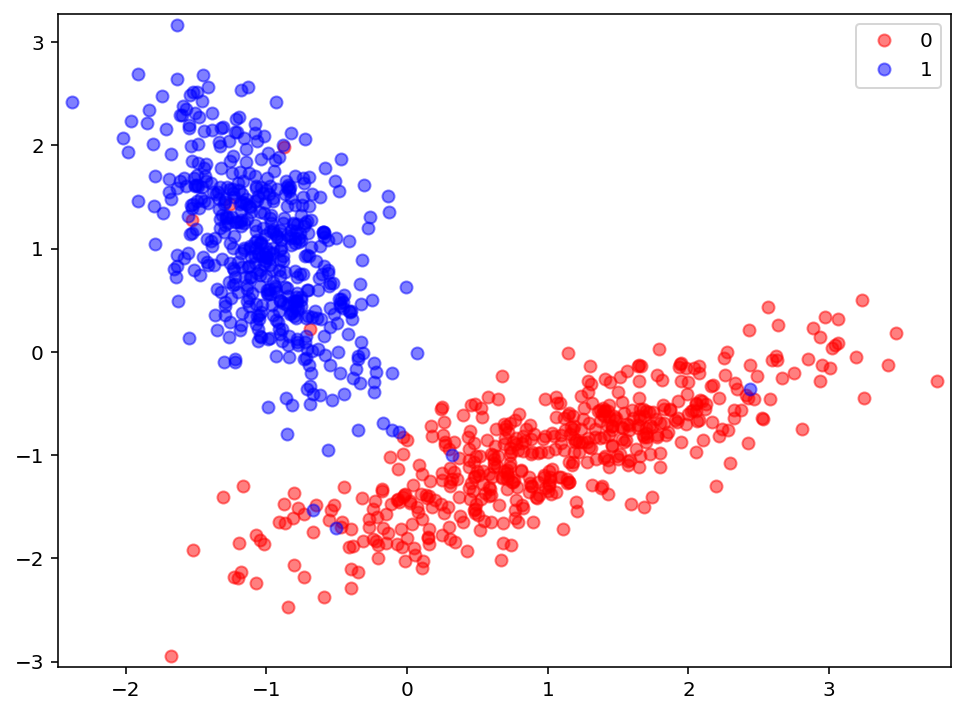

In [3]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=8, n_clusters_per_class=1)
plot_data(X, y)

Como vocês podem ver, o dataset gerado é muito simples. Nós já temos uma Regressão Linear disponível na lib do SKLearn. Vamos utilizá-la para mostrar como treinar e plotar uma fronteira de decisão linear.

LR coefficients: [[-2.4212136   2.82907276]]
LR intercept: [0.76426754]
Point class:  [0]
alpha =  -12.15751879310984


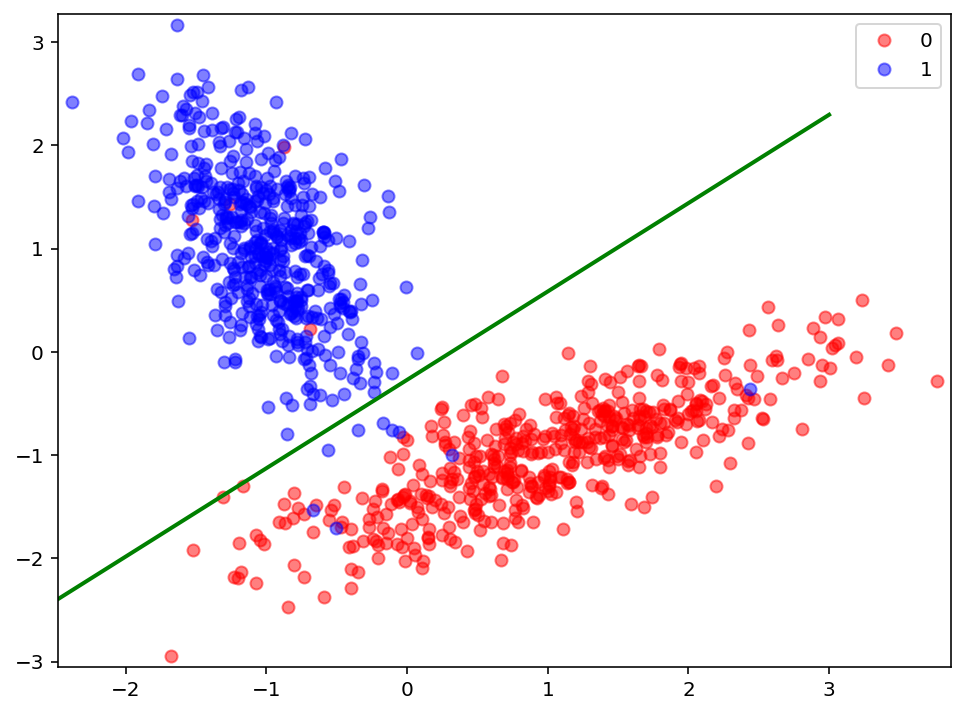

In [6]:
# create model
model = LogisticRegression()
model.fit(X, y)
print('LR coefficients:', model.coef_)
print('LR intercept:', model.intercept_)

plot_data(X, y)

limits = np.array([-3, 3])
boundary = -(model.coef_[0][0] * limits + model.intercept_[0]) / model.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

point = [(3, -2)]

print('Point class: ', model.predict(point))

alpha = point[0][0]*model.coef_[0][0] + point[0][1]*model.coef_[0][1] + model.intercept_[0]
print('alpha = ', alpha)

### Modelo Linear usando a *Sequential model API*

Como podemos ver acima, o dataset é linearmente separável. Vamos agora treinar um modelo linear usando a *Sequential model API* disponível [aqui](https://keras.io/getting-started/sequential-model-guide/). O model sequencial permite construir redes neurais profundas, adicionando camadas sequencialmente. Como queremos construir um simples modelo linear, vamos conectar os nódulos de entrada diretamente nos de saída.

Para o caso desse exemplo, um dataset binário (2 classes), nossa rede neural deve ter apenas uma camada com um nódulo, que representa a classificação binária.

A função *Dense* no *Keras* uma camada de rede neural totalmente conectada, inicializando automaticamente os pesos. É uma das principais funções do *Keras*. Seus argumentos são definidos como:

* *units*: número de nódulos da camada. Como temos um dataset binário, este deve ter apenas um nódulo.
* *input_shape*: apenas a primeira camada nos modelos Keras precisa especificar as dimensões do dado de entrada. No nosso caso, esta dimensão é 2, as coordenadas x e y. Como *input_shape* espera um vetor, no nosso caso é apenas uma tupla com um número.
* *activation*: a função de ativação de uma regressão linear é uma função "logística", ou, como chamado no Keras, uma função *sigmoid*.

Depois de construir nosso modelo, devemos compilá-lo usando a função *compile*. Esta função cria o modelo da rede neural, embora este não tenha sido treinado ainda. Os argumentos da função *compile* são definidos como:

* *optimizer*: qual otimizador usar para minimizar a função de perda. Há muitos otimizadores disponíveis e não entraremos em maiores detalhes. Usaremos nesse exemplo o otimizador *adam*, preferido no uso padrão.
* *loss*: a função de perda a ser minimizada. Por ser um problema binário, usaremos a *binary_crossentropy*.
* *metrics*: quais métricas serão reportadas. Para problemas de classificação, o padrão é utilizar a acurácia.

Após a compilação, devemos treinar nosso modelo. Os argumentos são:
* *x*: os dados de entrada
* *y*: as classes a serem predizidas
* *verbose*: setar para ver a saída do método
* *epochs*: número de vezes que o modelo deve passar pelos dados de treino. 

<Figure size 576x432 with 0 Axes>

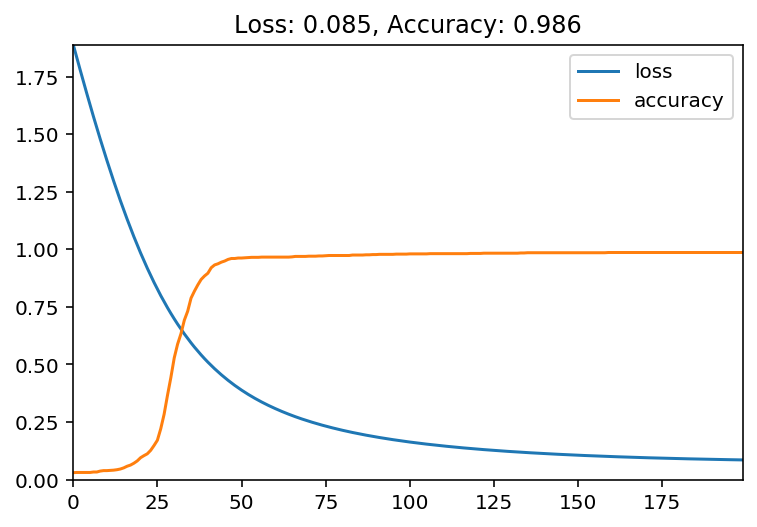

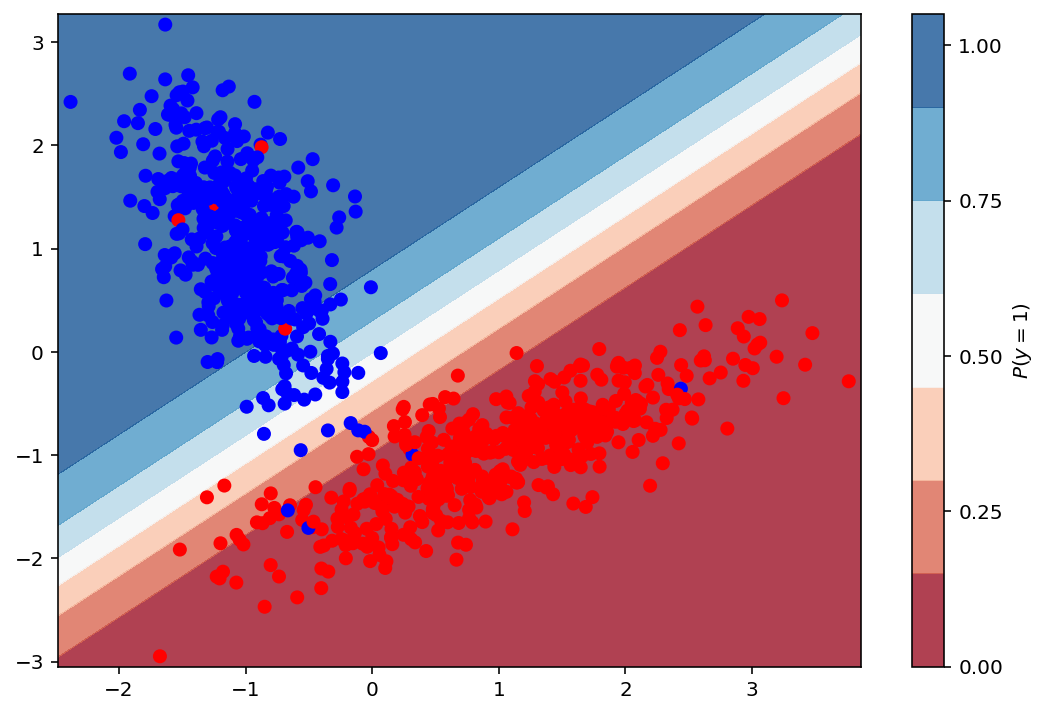

In [8]:
# create model
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history = model.fit(x=X, y=y, verbose=0, epochs=200)
plot_loss_accuracy(history)

plot_decision_boundary(lambda x: model.predict(x), X, y)

Podemos ver que o modelo Keras para uma regressão linear também é capaz de predizer esse tipo de dataset. Mas o que acontece se nossos dados forem um pouco mais complexos?

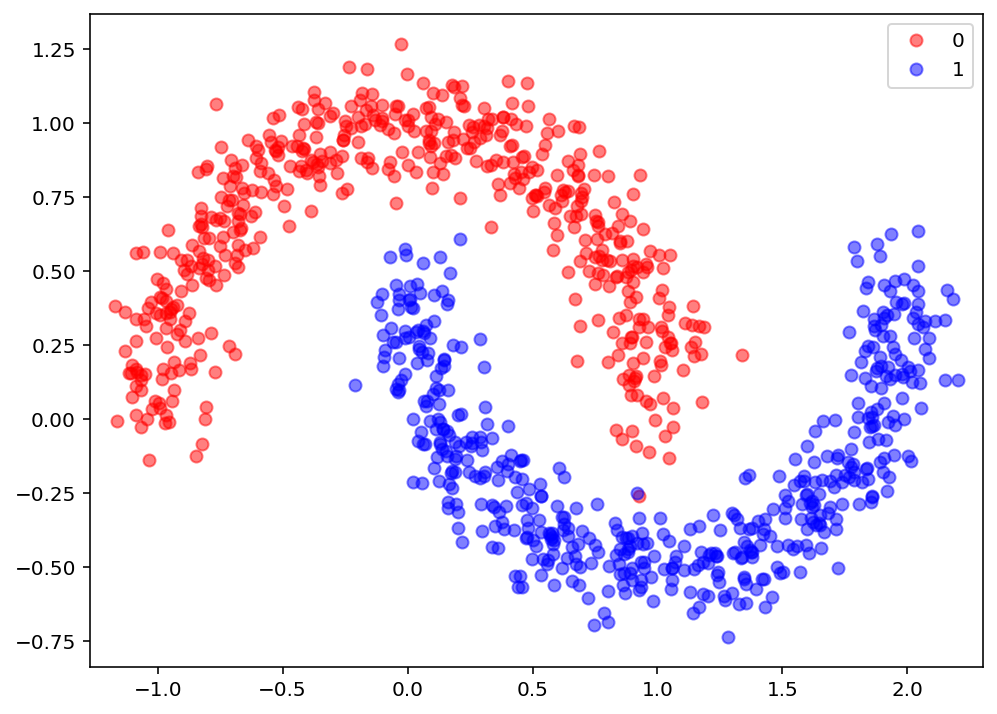

In [9]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
plot_data(X, y)

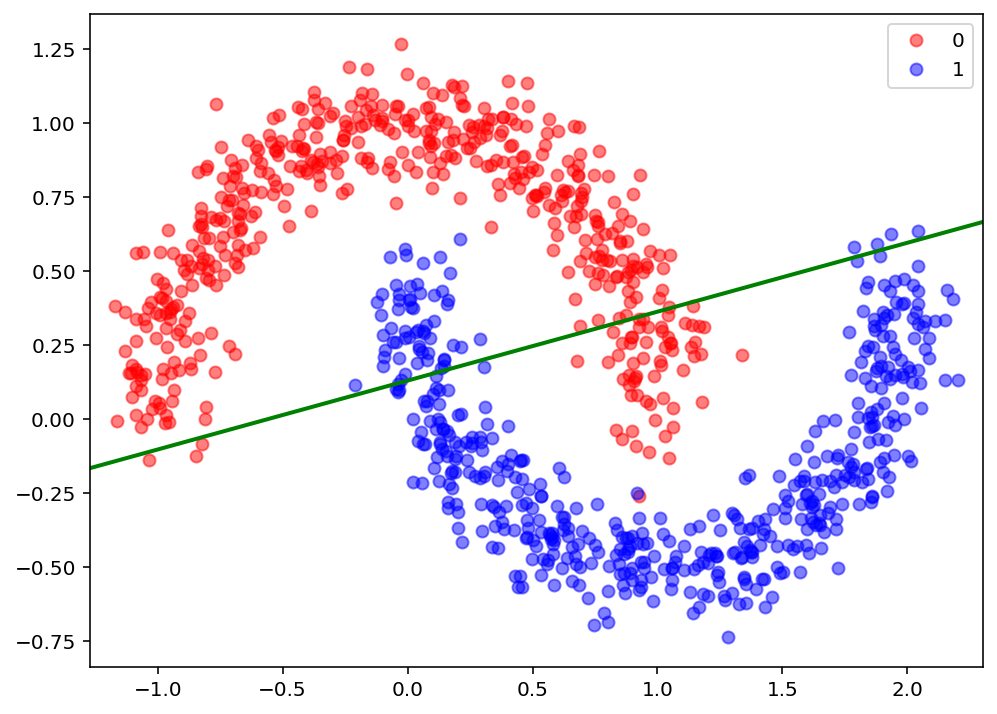

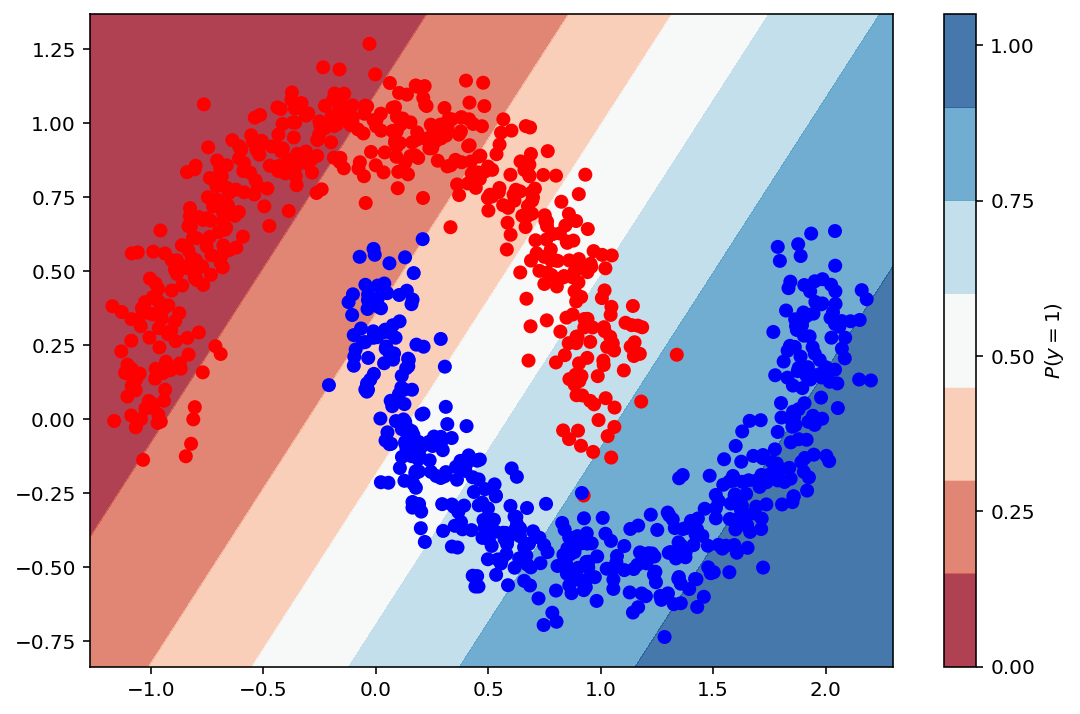

In [10]:
model = LogisticRegression()
model.fit(X, y)

plot_data(X, y)

limits = np.array([-3, 3])
boundary = -(model.coef_[0][0] * limits + model.intercept_[0]) / model.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

###########################################

model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=50)

plot_decision_boundary(lambda x: model.predict(x), X, y)

### Rede neural profunda

Vamos agora treinar uma Rede Neural (ANN) para melhor classificar esse dataset mais complexo.

Seguiremos os mesmo passos utilizados para criar a regressão linear, mas, ao invés de adicionar apenas uma camada (ond a camada de entrada e saída são a mesma), vamos adicionar várias camadas conectadas, onde a saída de uma camada é a entrada da outra.

Para este exemplo, vamos utilizar uma ANN com 3 camadas: a camada de entrada, 1 camada escondida e a camada de saída. Vamos seguir os seguintes padrões:

* A camada de saída ainda usará a ativação *sigmoid* por se tratar de um problema binário. Além disso, esta deve ter 1 nódulo.
* As outras camadas utilizarão a ativação *tanh*
* Iremos reduzindo o número de nódulos em cada camada subsequente. Isto é uma prática comum em rede neurais.

<Figure size 576x432 with 0 Axes>

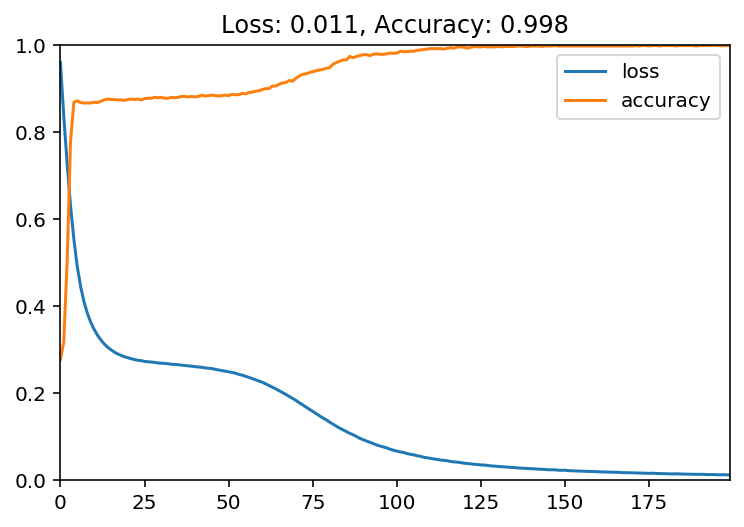

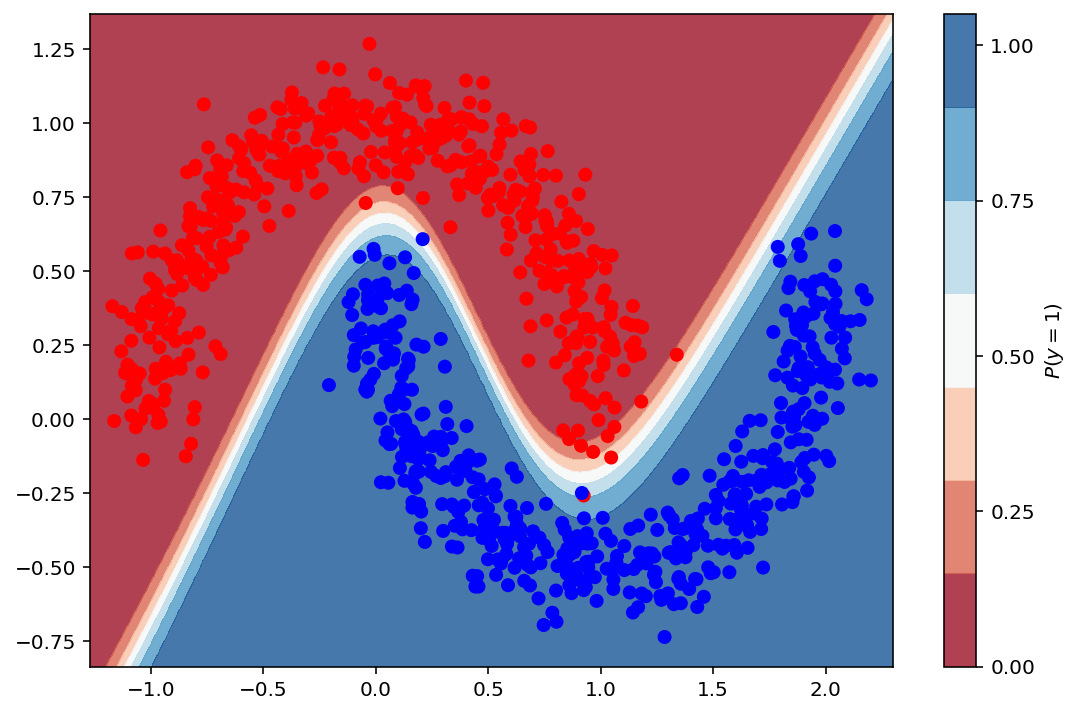

In [12]:
# create the model
model = Sequential()
model.add(Dense(8, input_shape=(2,), activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=200)

plot_loss_accuracy(history)

plot_decision_boundary(lambda x: model.predict(x), X, y)

Vamos agora testar um dataset em círculos e ver o resultado do nosso modelo.

<Figure size 576x432 with 0 Axes>

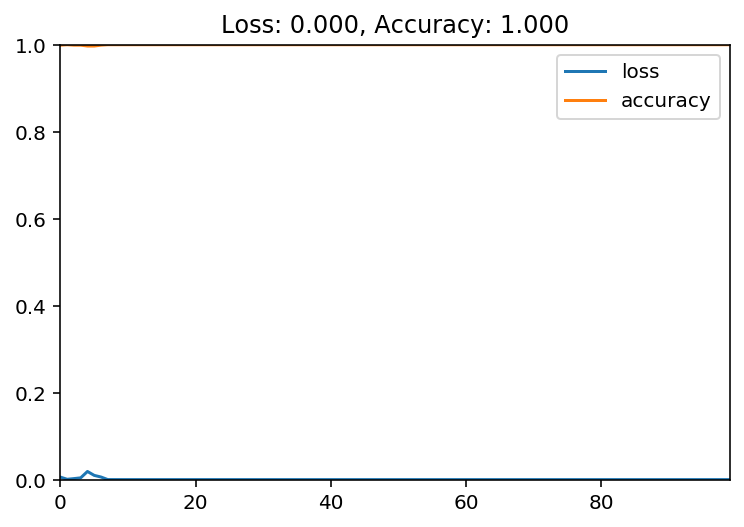

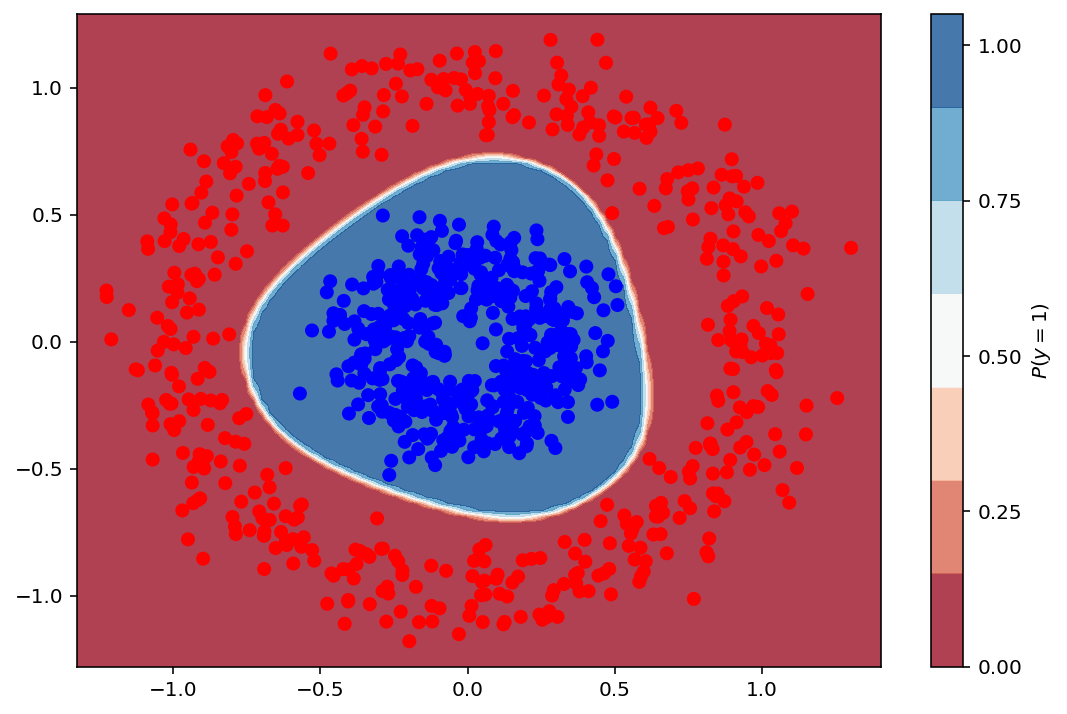

In [17]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=0)

# create the model

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

plot_decision_boundary(lambda x: model.predict(x), X, y)

### Dataset mais complexo - Senóides

Vamos tentar agora classificar um dataset senoidal. Nos exemplos anteriores, as classes podiam ser separadas por apenas uma fronteira de decisão não-linear.

Nesse próximo exemplo, precisaremos de mais que uma camada de decisão.

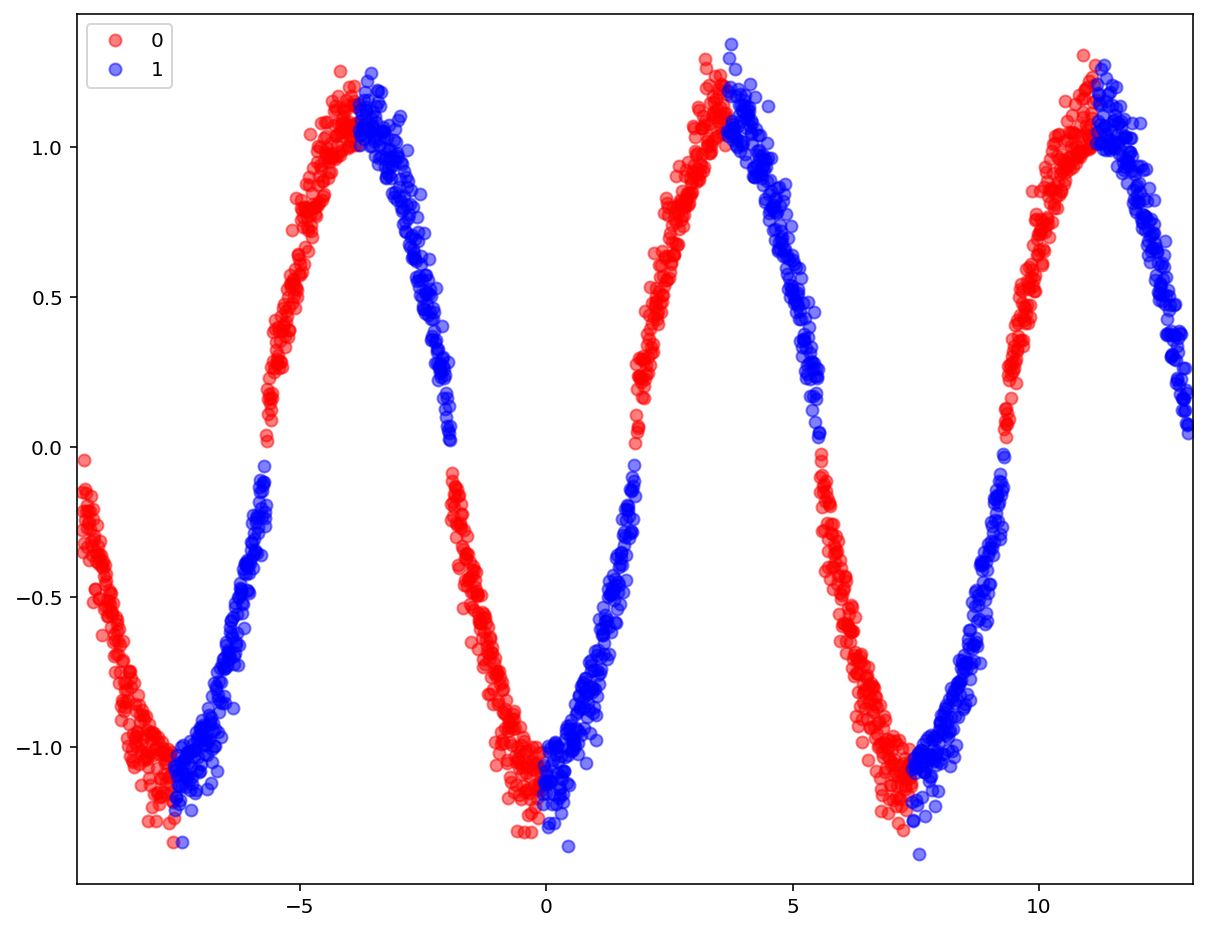

In [20]:
X, y = make_sine_wave()

plot_data(X, y, figsize=(10, 8))

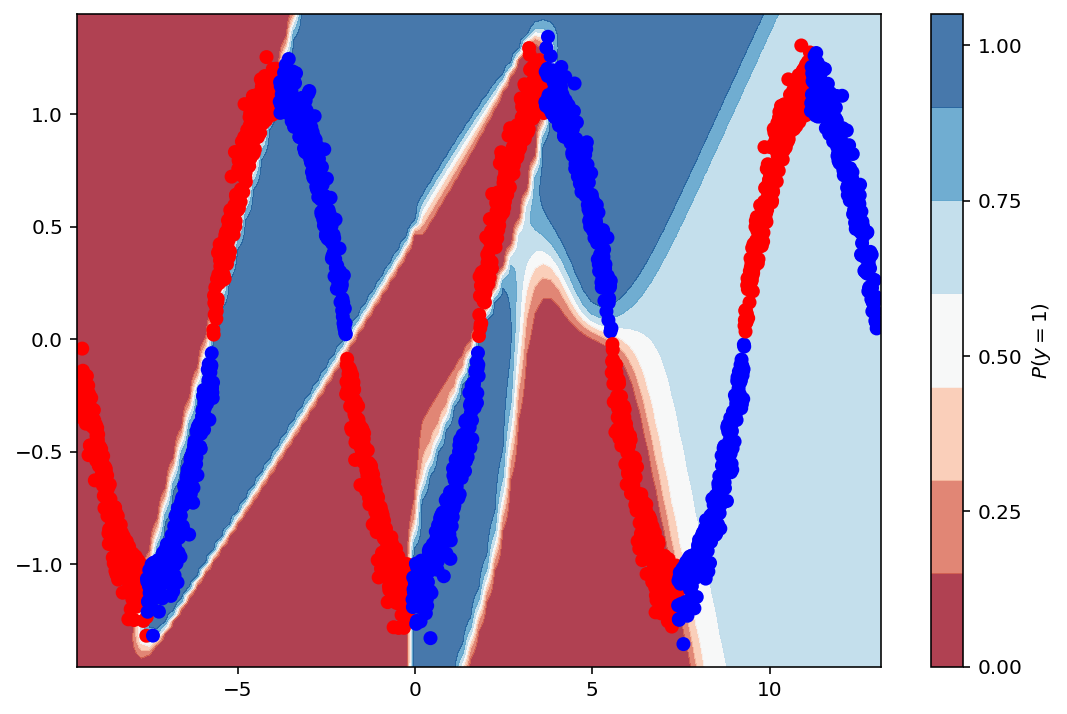

In [21]:
# create the model

model = Sequential()
model.add(Dense(8, input_shape=(2,), activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_decision_boundary(lambda x: model.predict(x), X, y)

Como podemos ver, precisaremos de um modelo mais complexo para aumentar nossa acurácia. Vamos tentar adicionar mais uma camada escondida, além de aumentar o número de nódulos por camada. **A escolha do número certo de camadas e nódulo é mais uma arte que ciência!**

<Figure size 576x432 with 0 Axes>

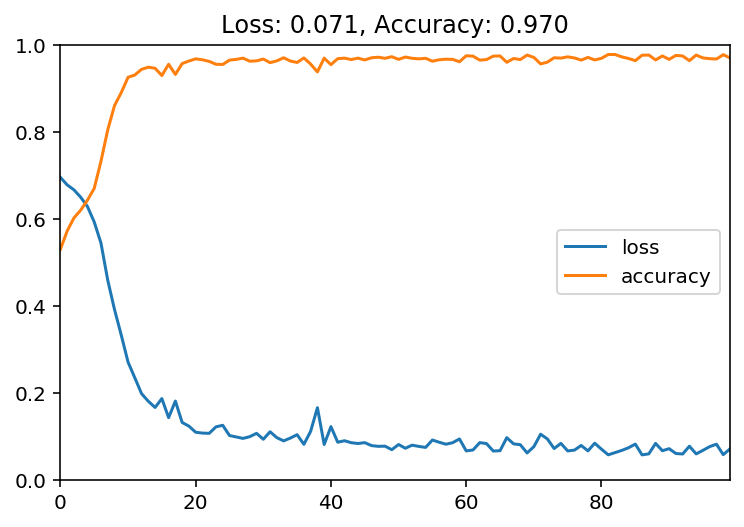

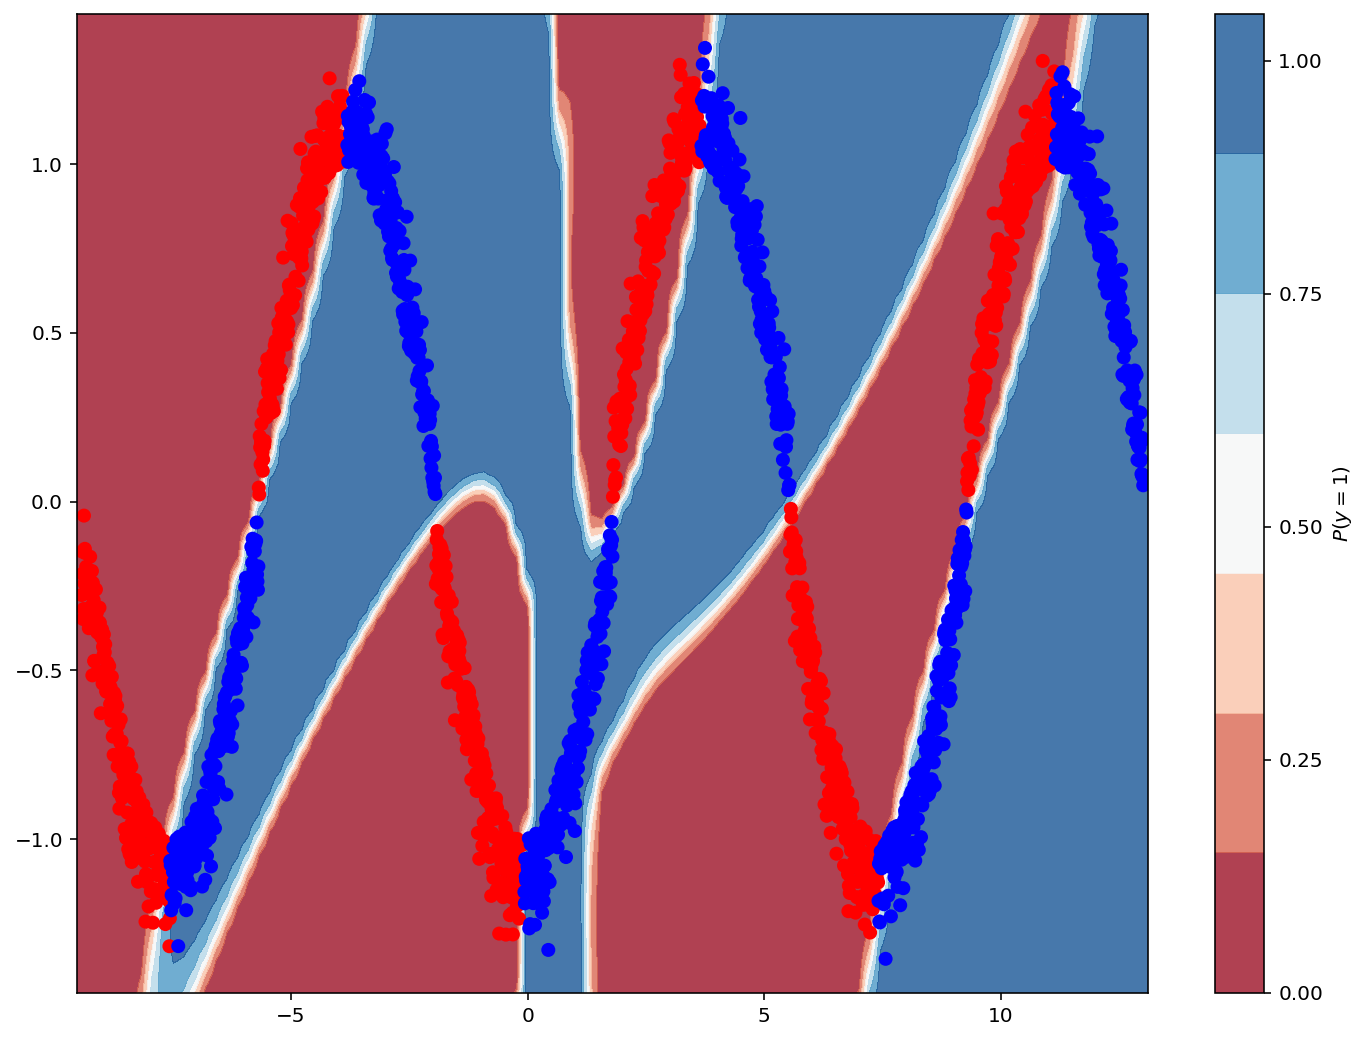

In [23]:
# create the model

model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12, 9))

### Classificação multiclasse

Vamos testar agora a biblioteca Keras para um problema não-binário, no caso, um problema com 3 classes.

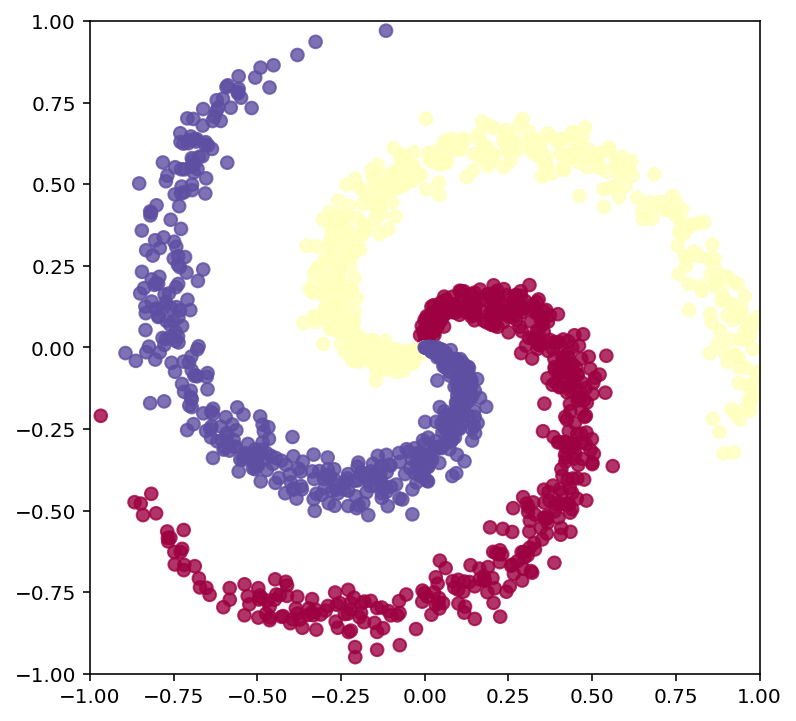

In [24]:
X, y = make_multiclass(K=3)

Primeiramente, vamos testar uma solução linear. Por se tratar de um problem não-binário, não vamos mais utilizar a função *sigmoid* de ativação. Ao invés disso, utilizaremos a ativação *softmax*, que nada mais é que uma generalização da regressão linear para problemas com mais que 3 classes.

<Figure size 576x432 with 0 Axes>

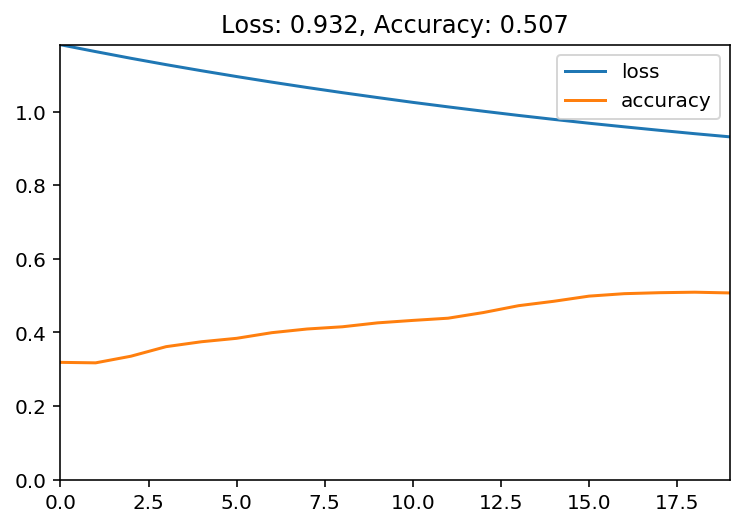

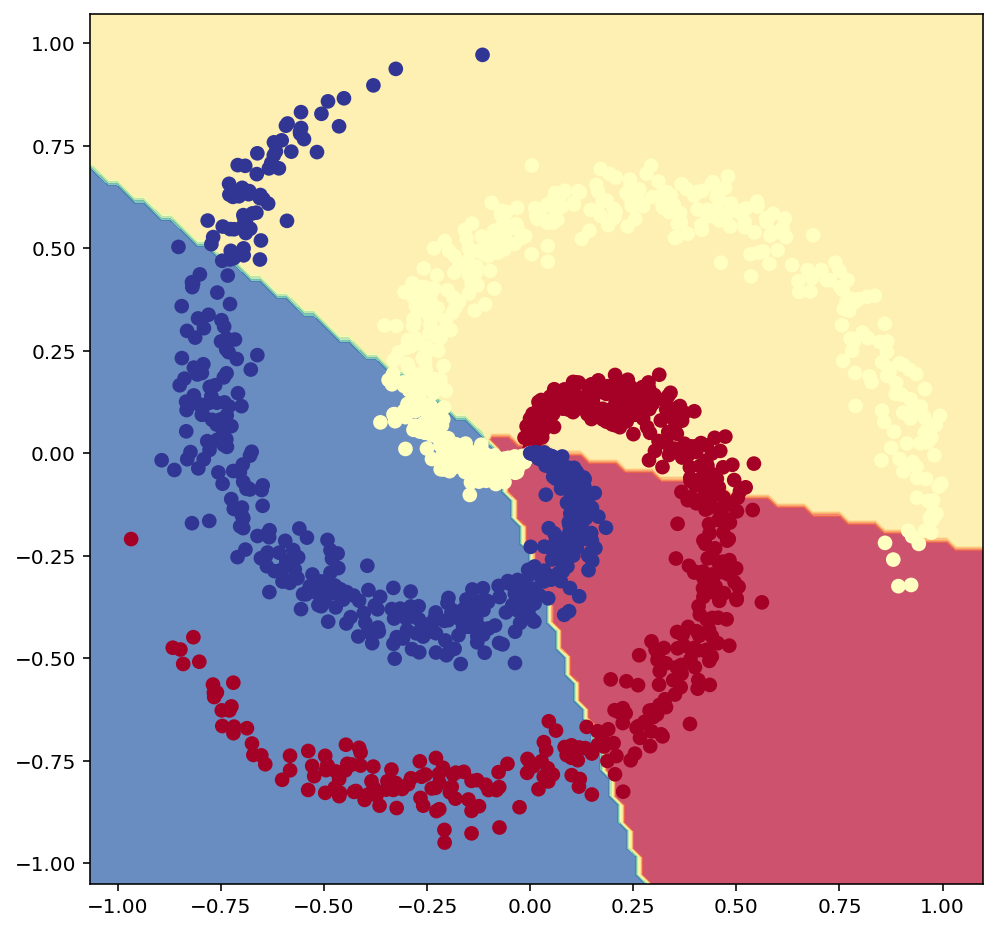

In [25]:
# create the model
model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=20)
plot_loss_accuracy(history)

plot_multiclass_decision_boundary(model, X, y)

Como podemos ver, o modelo linear também não é capaz de predizer corretamente esse dataset. Vamos passar por alguns pontos do nosso modelo:

* Para o caso binário, um nódulo de saída é capaz de predizer as 2 classes (0 e 1), pois podemos calcular a probabilidade da classe 1 como sendo P(1), enquanto a probabilidade da outra classe é simplesmente (1 - P(1)). Para o caso multiclasse, faz mais sentido ter um nódulo para cada classe. Por isso, utilizamos 3 nódulos.
* A função softmax escala as probabilidades dos nódulos de saída para que a soma deles seja 1, mas não de uma forma linear (dividindo cada probabilidade pela soma), e sim usando uma função exponencial. Por hora, vamos pensar na *softmax* como uma normalização que nos permite interpretar as probabilidades de saída.
* No caso binário, a função de perda é a binary_crossentropy. No caso multiclasse, utilizamos a função categorical_crossentropy.
* Para o caso binário, usamos o vetor y diretamente na função de *fit*. Quando lidamos com um caso multiclasse, precisamos ter uma matriz onde cada linha contém valores 0, exceto na coluna que representa a classe, onde o valor é 1.

Vamos testar agora, utilizar uma rede mais complexa para predizer nosso dataset.

<Figure size 576x432 with 0 Axes>

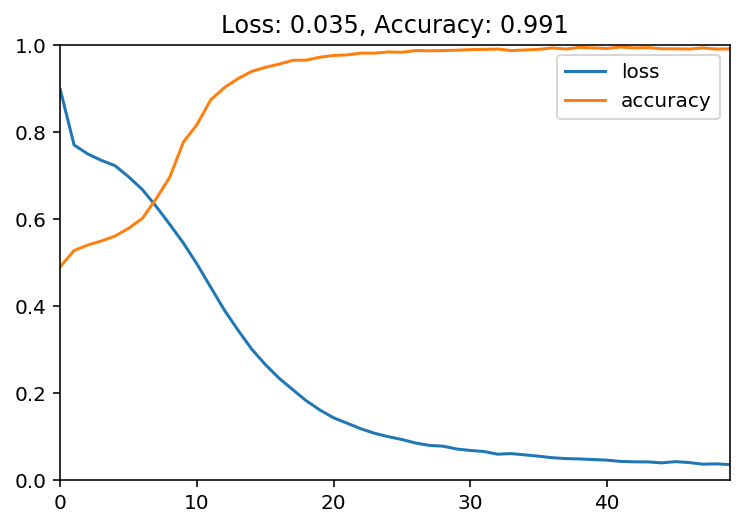

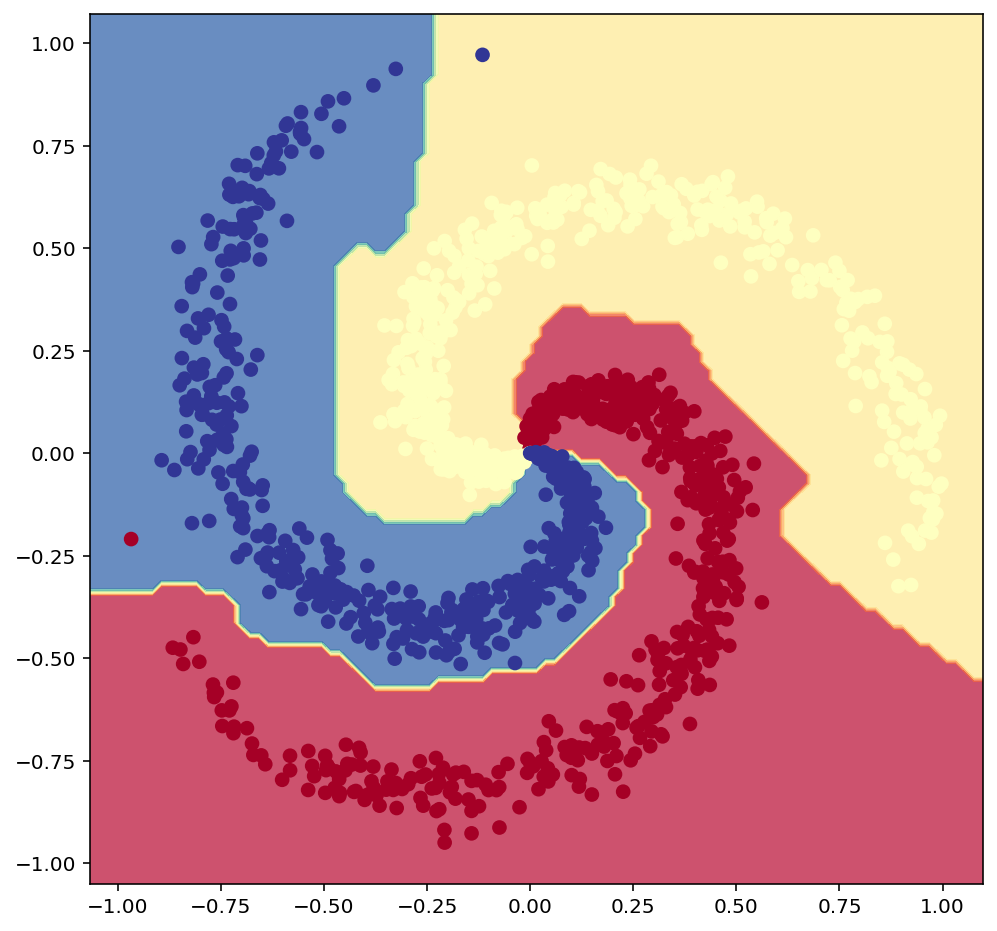

In [26]:
# create the model
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)

plot_loss_accuracy(history)
plot_multiclass_decision_boundary(model, X, y)